In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import os
print(os.listdir("E:/IAD/Intern/05_CMAPSS/CMAPSSData"))

['readme.txt', 'readme_vietnamese.txt', 'RUL_FD001.txt', 'RUL_FD002.txt', 'RUL_FD003.txt', 'RUL_FD004.txt', 'test_FD001.txt', 'test_FD002.txt', 'test_FD003.txt', 'test_FD004.txt', 'train_FD001.txt', 'train_FD002.txt', 'train_FD003.txt', 'train_FD004.txt']


In [2]:
dataPath = 'E:/IAD/Intern/05_CMAPSS/CMAPSSData'

In [3]:
setNumber = 3

In [4]:
id_col = ['id']
cycle_col = ['cycle']
setting_cols = ['setting1', 'setting2', 'setting3']
sensor_cols = ['sensor' + str(i) for i in range(1, 22)]
rul_col = ['RUL']
all_cols = id_col + cycle_col + setting_cols + sensor_cols + rul_col

# Load train/test data with RUL

In [5]:
# This section is to load data
def loadData(fileName):
    data = pd.read_csv(fileName, sep=" ", header=None)
    data.drop([26, 27], axis = 1, inplace=True)
    data.columns = id_col + cycle_col + setting_cols +sensor_cols
    return data

In [6]:
# load train RUL also returns the max cycle, and this max cycle is also the life cylce
def addTrainRul(data, decrease_threshold=None):
    lifeCycles = {mcId: data[data['id']==mcId]['cycle'].max() for mcId in data['id'].unique()}
    if decrease_threshold == None: decrease_threshold = 1
    ruls = [lifeCycles[row[0]] - decrease_threshold if row[1] < decrease_threshold else lifeCycles[row[0]] - row[1] for row in data.values]
    data['RUL'] = ruls
    return lifeCycles
    
# use this last one only, return the data as well as the max life cycles
def loadTrainData(setNumber, decrease_threshold=None):
    fileName = dataPath + '/train_FD00' + str(setNumber) + '.txt'
    data = loadData(fileName)
    lifeCycles = addTrainRul(data, decrease_threshold)
    return data, lifeCycles

In [7]:
decrease_threshold = None
train, trainLifeCycles = loadTrainData(setNumber, decrease_threshold)

In [8]:
def loadTestRul(fileName):
    data = pd.read_csv(fileName, sep = " ", header=None)
    data.drop([1], axis=1, inplace=True)
    data.columns = ['RUL']
    return data
def addTestRul(data, rulData, decrease_threshold=None):
    testRuls = {i+1: rulData.iloc[i, 0] for i in range(len(rulData))}
    lifeCycles = {mcId: data[data['id']==mcId]['cycle'].max() + testRuls[mcId] for mcId in data['id'].unique()}
    if decrease_threshold == None: decrease_threshold = 1
    ruls = [lifeCycles[row[0]] - decrease_threshold if row[1] < decrease_threshold else lifeCycles[row[0]] - row[1] for row in data.values]
    data['RUL'] = ruls
    return lifeCycles
# Use this last one only => return data as well as the max life cycles for each machine
def loadTestData(setNumber, decrease_threshold=None):
    data = loadData(dataPath + '/test_FD00' +str(setNumber)+'.txt')
    rulData = loadTestRul(dataPath + '/RUL_FD00' + str(setNumber)+'.txt')
    lifeCycles = addTestRul(data, rulData, decrease_threshold)
    return data, lifeCycles

In [9]:
# Also make test RUL becomes piecewise
test, testLifeCycles = loadTestData(setNumber, decrease_threshold)

ParserError: Error tokenizing data. C error: Expected 1 fields in line 2, saw 2


# Plot data to see its distribution

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
# As of feature selection they often select: 7, 8, 9, 12, 16, 17, 20  (manual selection based on sensor trends)
def plotSensorDataOfId(data, mcId):
    plt.figure(figsize=(30, 20))
    for i in range(21):
        sensor = 'sensor'+str(i+1)
        plt.subplot(10, 3, i+1).set_title(sensor)
        ssdata = data[data['id']==mcId]
        plt.plot(ssdata['cycle'], ssdata[sensor])
    plt.tight_layout()

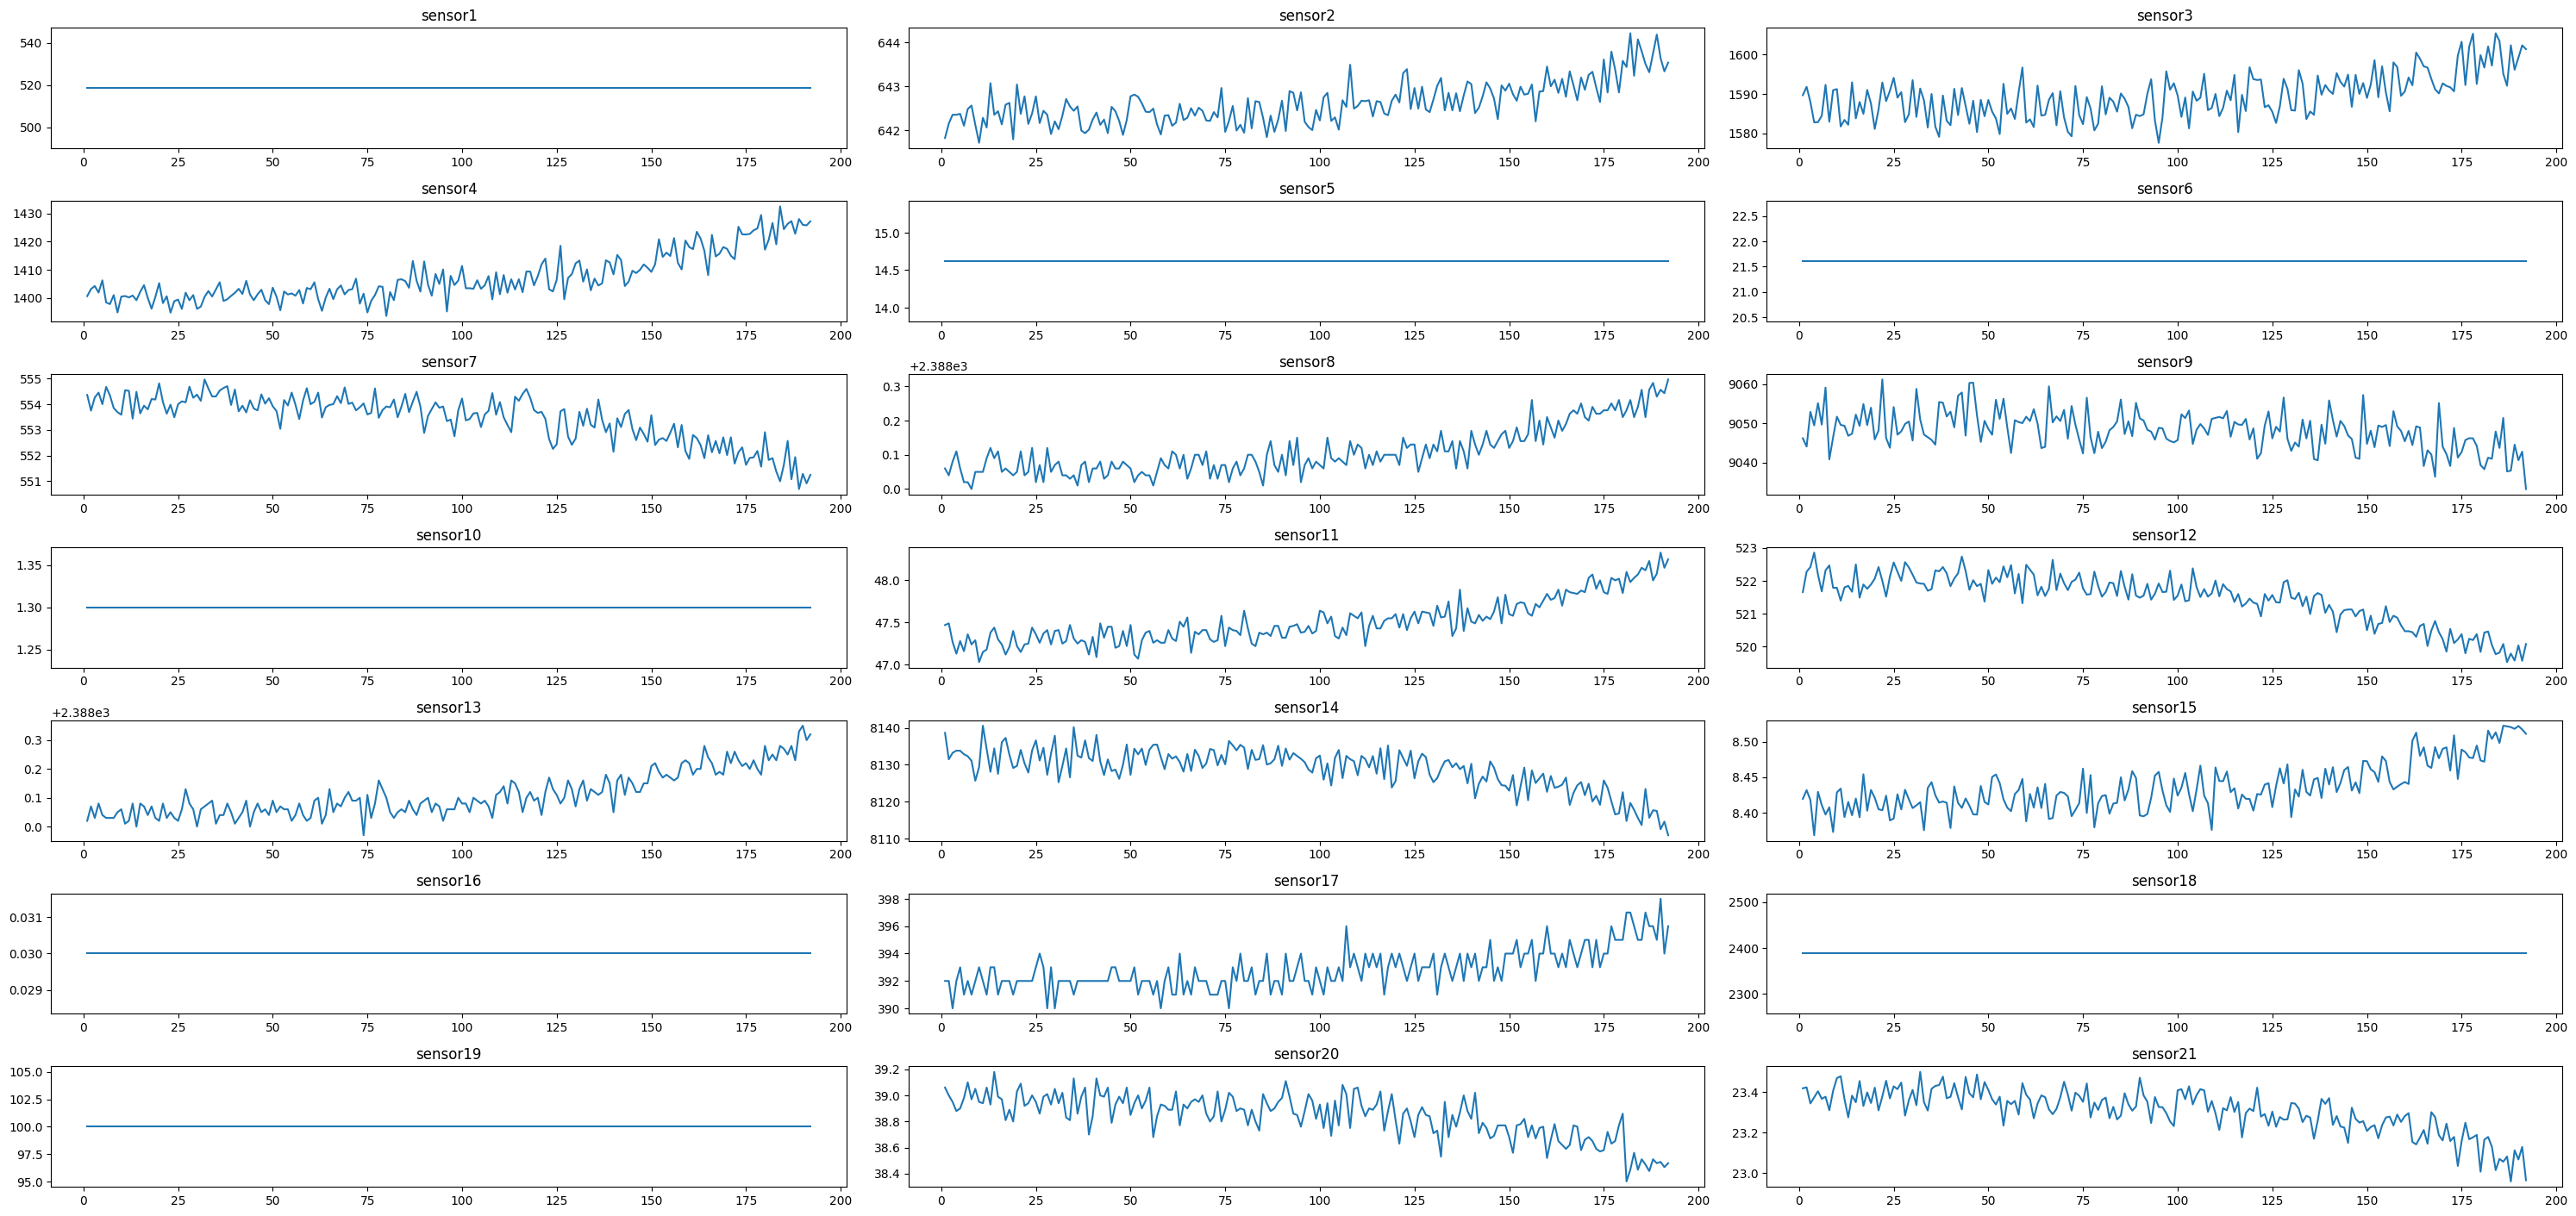

In [ ]:
plotSensorDataOfId(train, 1)

In [ ]:
def plotDataDistribution(data):
    sensors = []
    plt.figure(figsize=(30, 10))
    for i in range(21):
        sensor = 'sensor'+str(i+1)
        if(len(data[sensor].unique())>1):
            sensors.append(sensor)
            plt.subplot(3, 10, i+1)
            sns.distplot(data[sensor])
    plt.tight_layout()
    return sensors

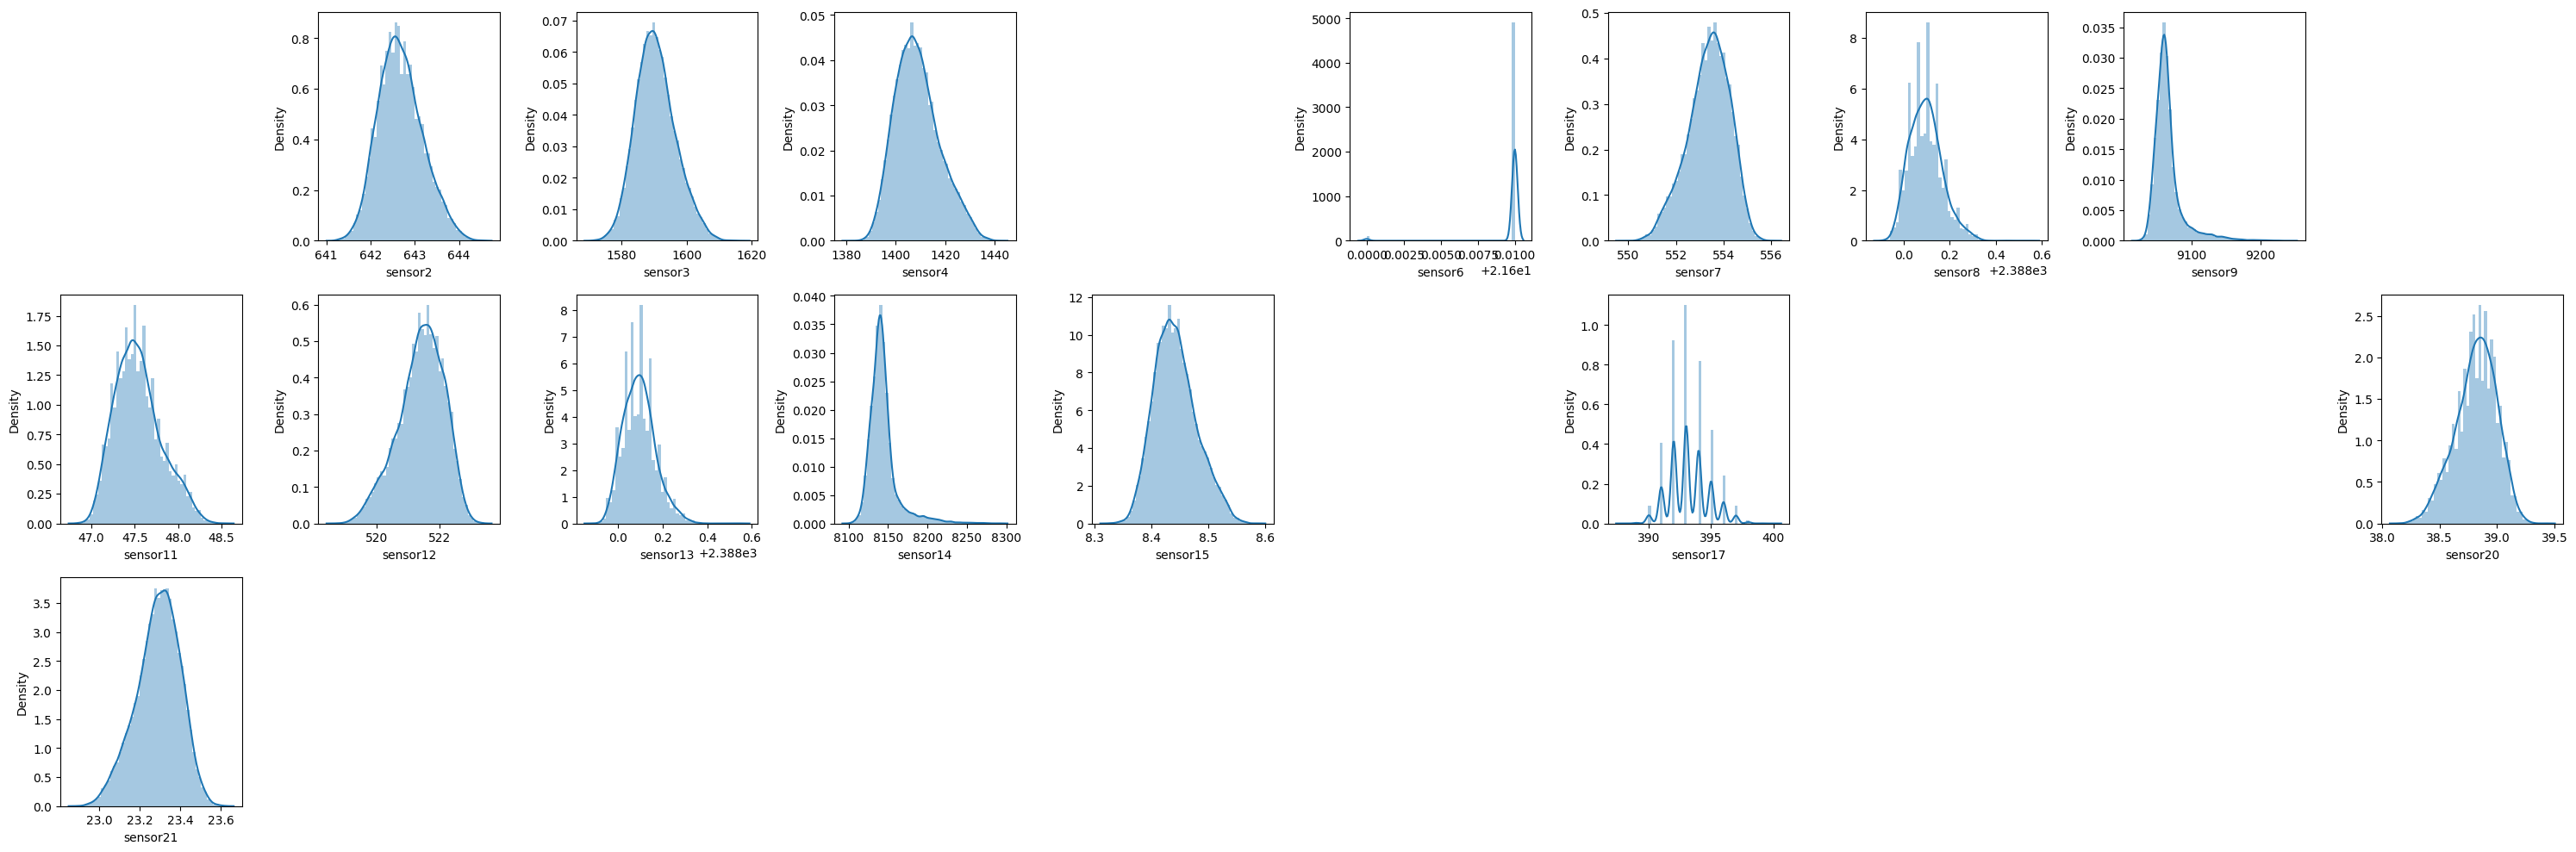

In [ ]:
# As of feature selection they often select: 7, 8, 9, 12, 16, 17, 20 => Why 16?
cols = plotDataDistribution(train)

In [ ]:
def plotCorrelation(data):
    corr = data.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool_)
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(10, 10))
    sns.heatmap(data.corr(), square=True, mask=mask, cbar_kws={"shrink": 0.5})

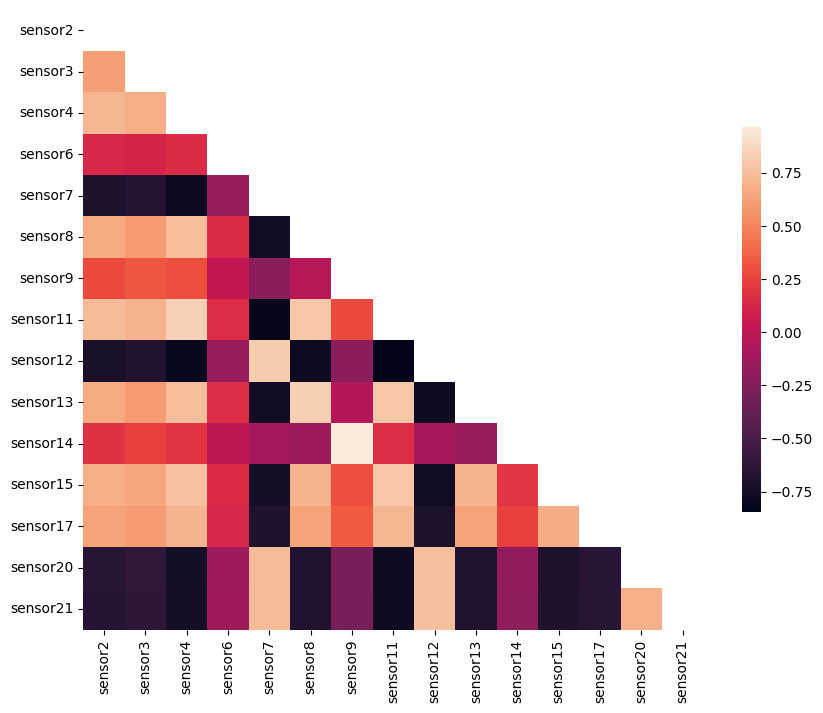

In [ ]:
plotCorrelation(train[cols])

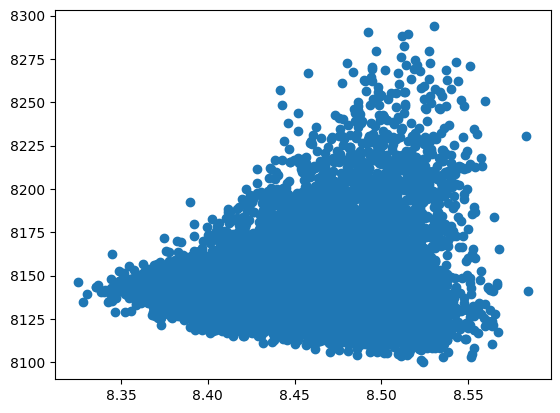

In [ ]:
plt.scatter(train['sensor15'].values, train['sensor14'].values)

In [ ]:
def plotCorrelationOfID(data, mcId):
    data1 = data[data['id']==mcId]
    data1 = data1.drop(['id'], axis = 1)
    corr = data1.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool_)
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(10, 10))
    sns.heatmap(data1.corr(), square=True, mask=mask, cbar_kws={"shrink": 0.5})

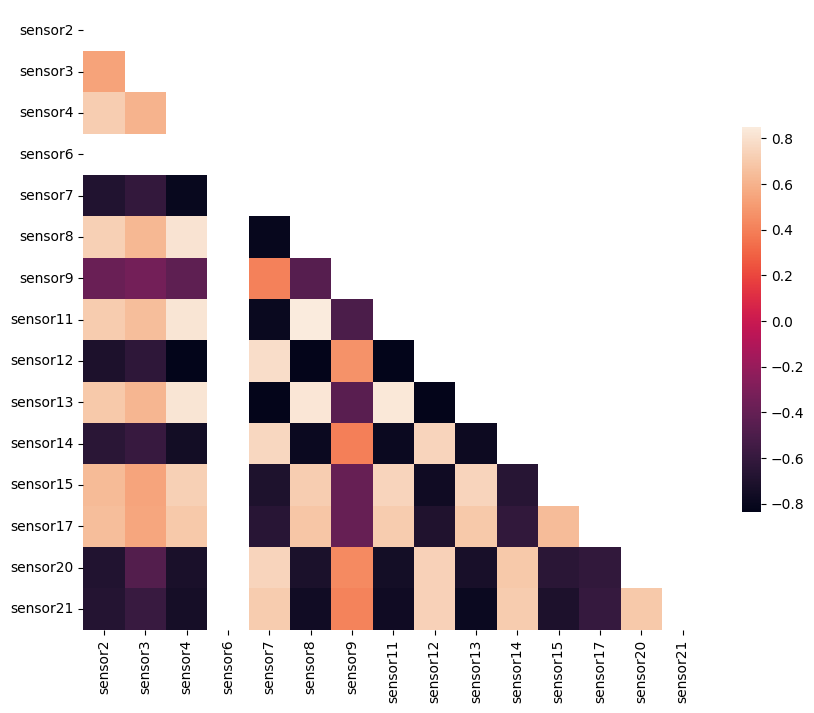

In [ ]:
plotCorrelationOfID(train[['id']+cols], 1)

# Scale

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Scale the data and return the scaled data in form of a df and the scaler (will generate the scaler if doesn't pass it)
def scaleData(data, scaler=None):
    scaled_fields = setting_cols+sensor_cols
    if scaler == None:
        scaler = StandardScaler().fit(data[scaled_fields].values)
#         scaler = MinMaxScaler().fit(data[scaled_fields].values)
    scaled_data = scaler.transform(data[scaled_fields].values)
    scaled_df0 = pd.DataFrame(scaled_data)
    scaled_df0.columns = scaled_fields
    scaled_df1 = data.copy()
    for i in range(len(scaled_fields)):
        theField = scaled_fields[i]
        scaled_df1[theField] = scaled_df0[theField]
    return scaled_df1, scaler

In [ ]:
# Scaled train
scaled_train, scaler = scaleData(train)
# Scaled test
scaled_test, scaler = scaleData(test, scaler)

# Plot to check the distribution are still the same after scaling

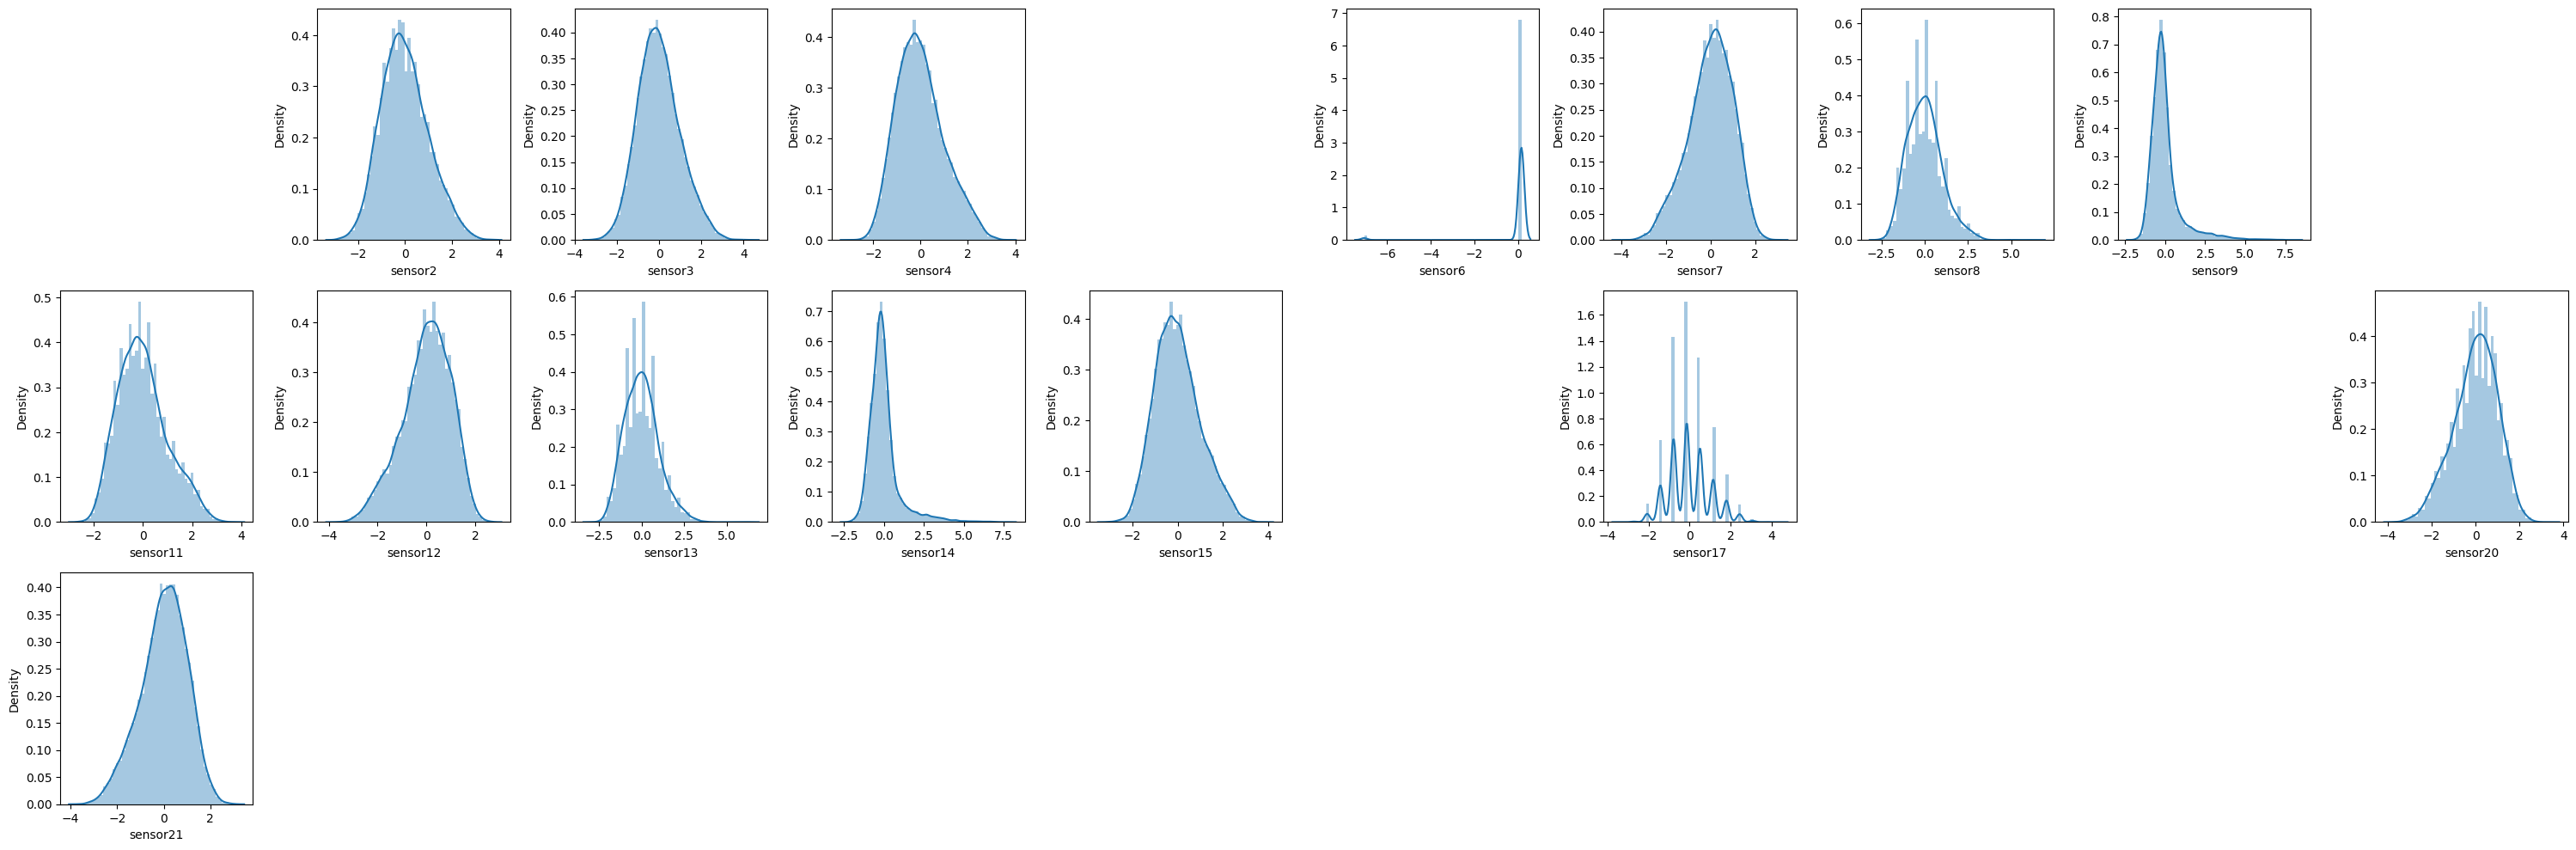

In [ ]:
# plot to make sure that the scaled data still keep its shape.
cols = plotDataDistribution(scaled_train)

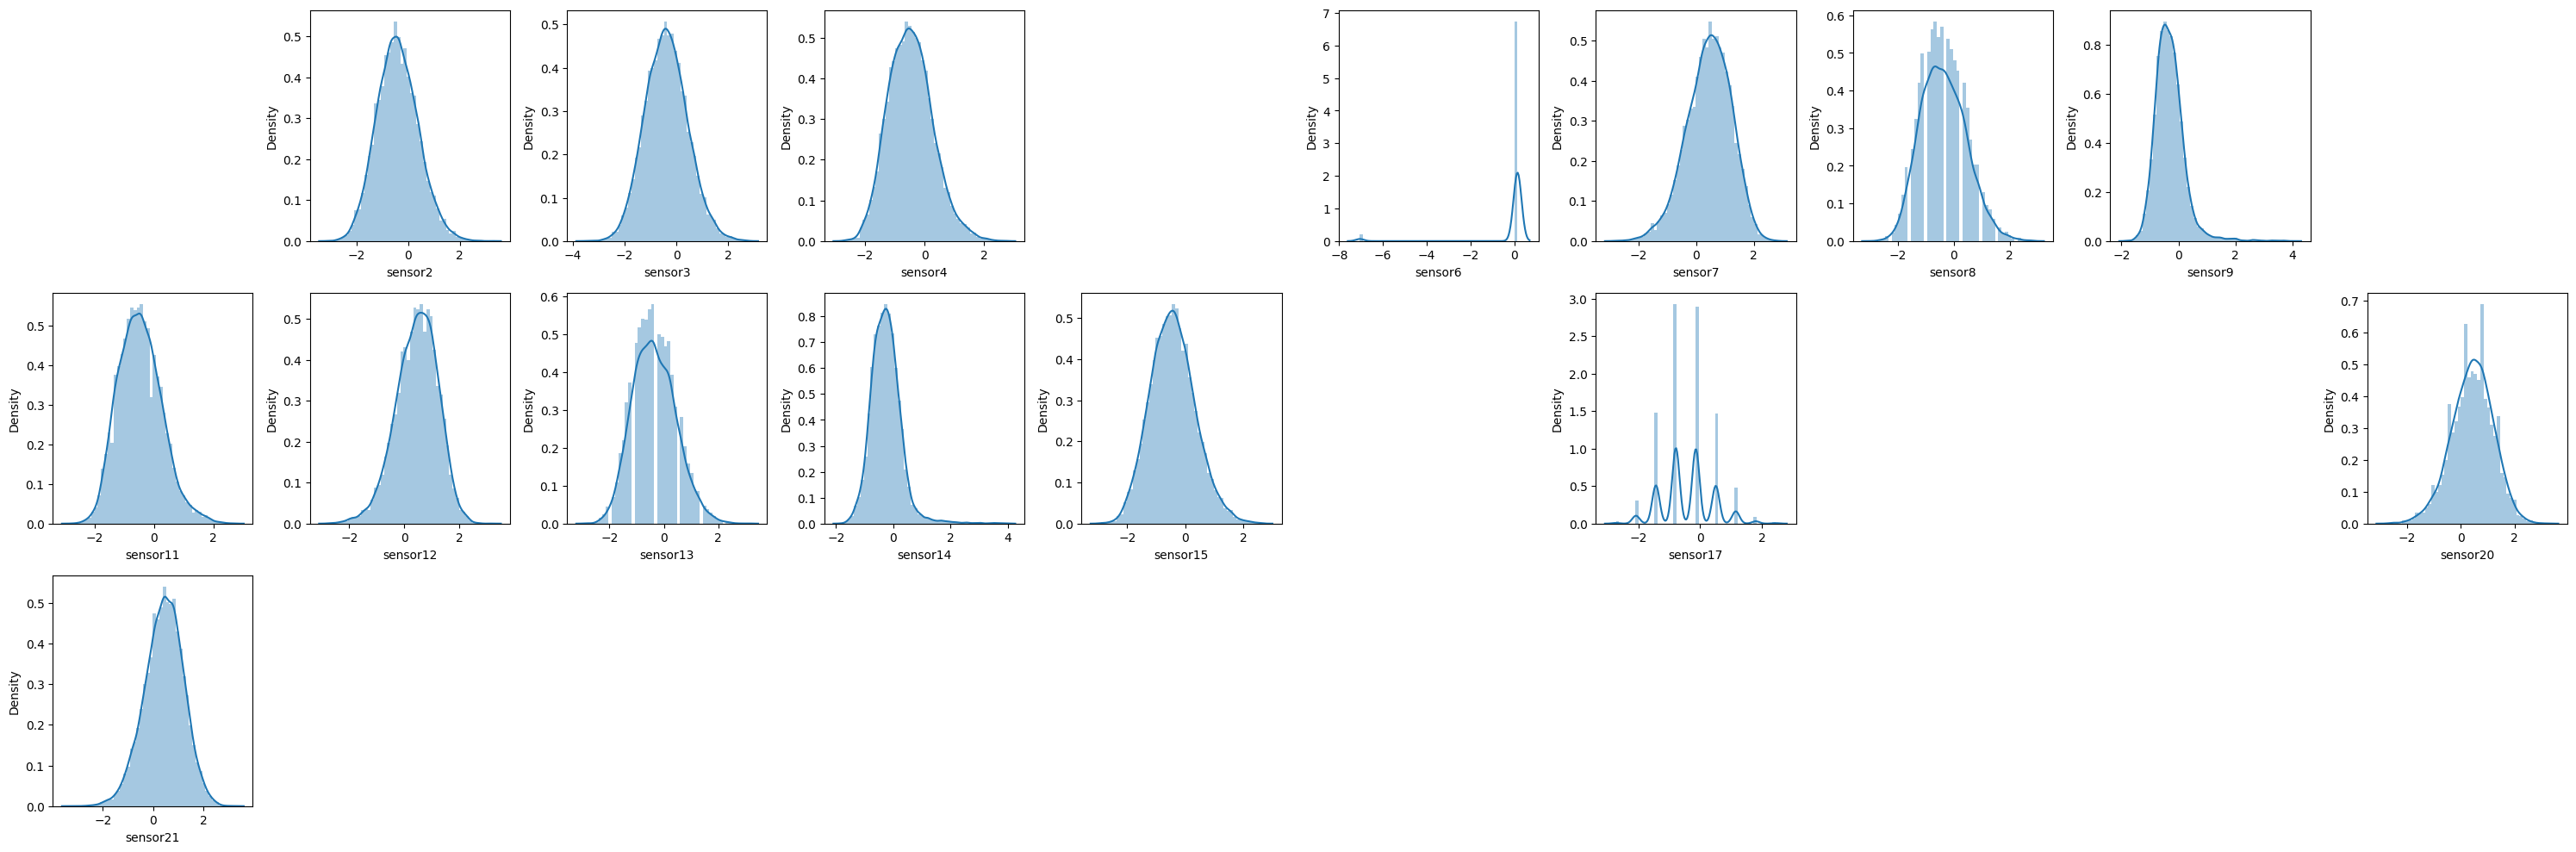

In [ ]:
#plot to see if the data keeps its distribution
cols = plotDataDistribution(scaled_test)

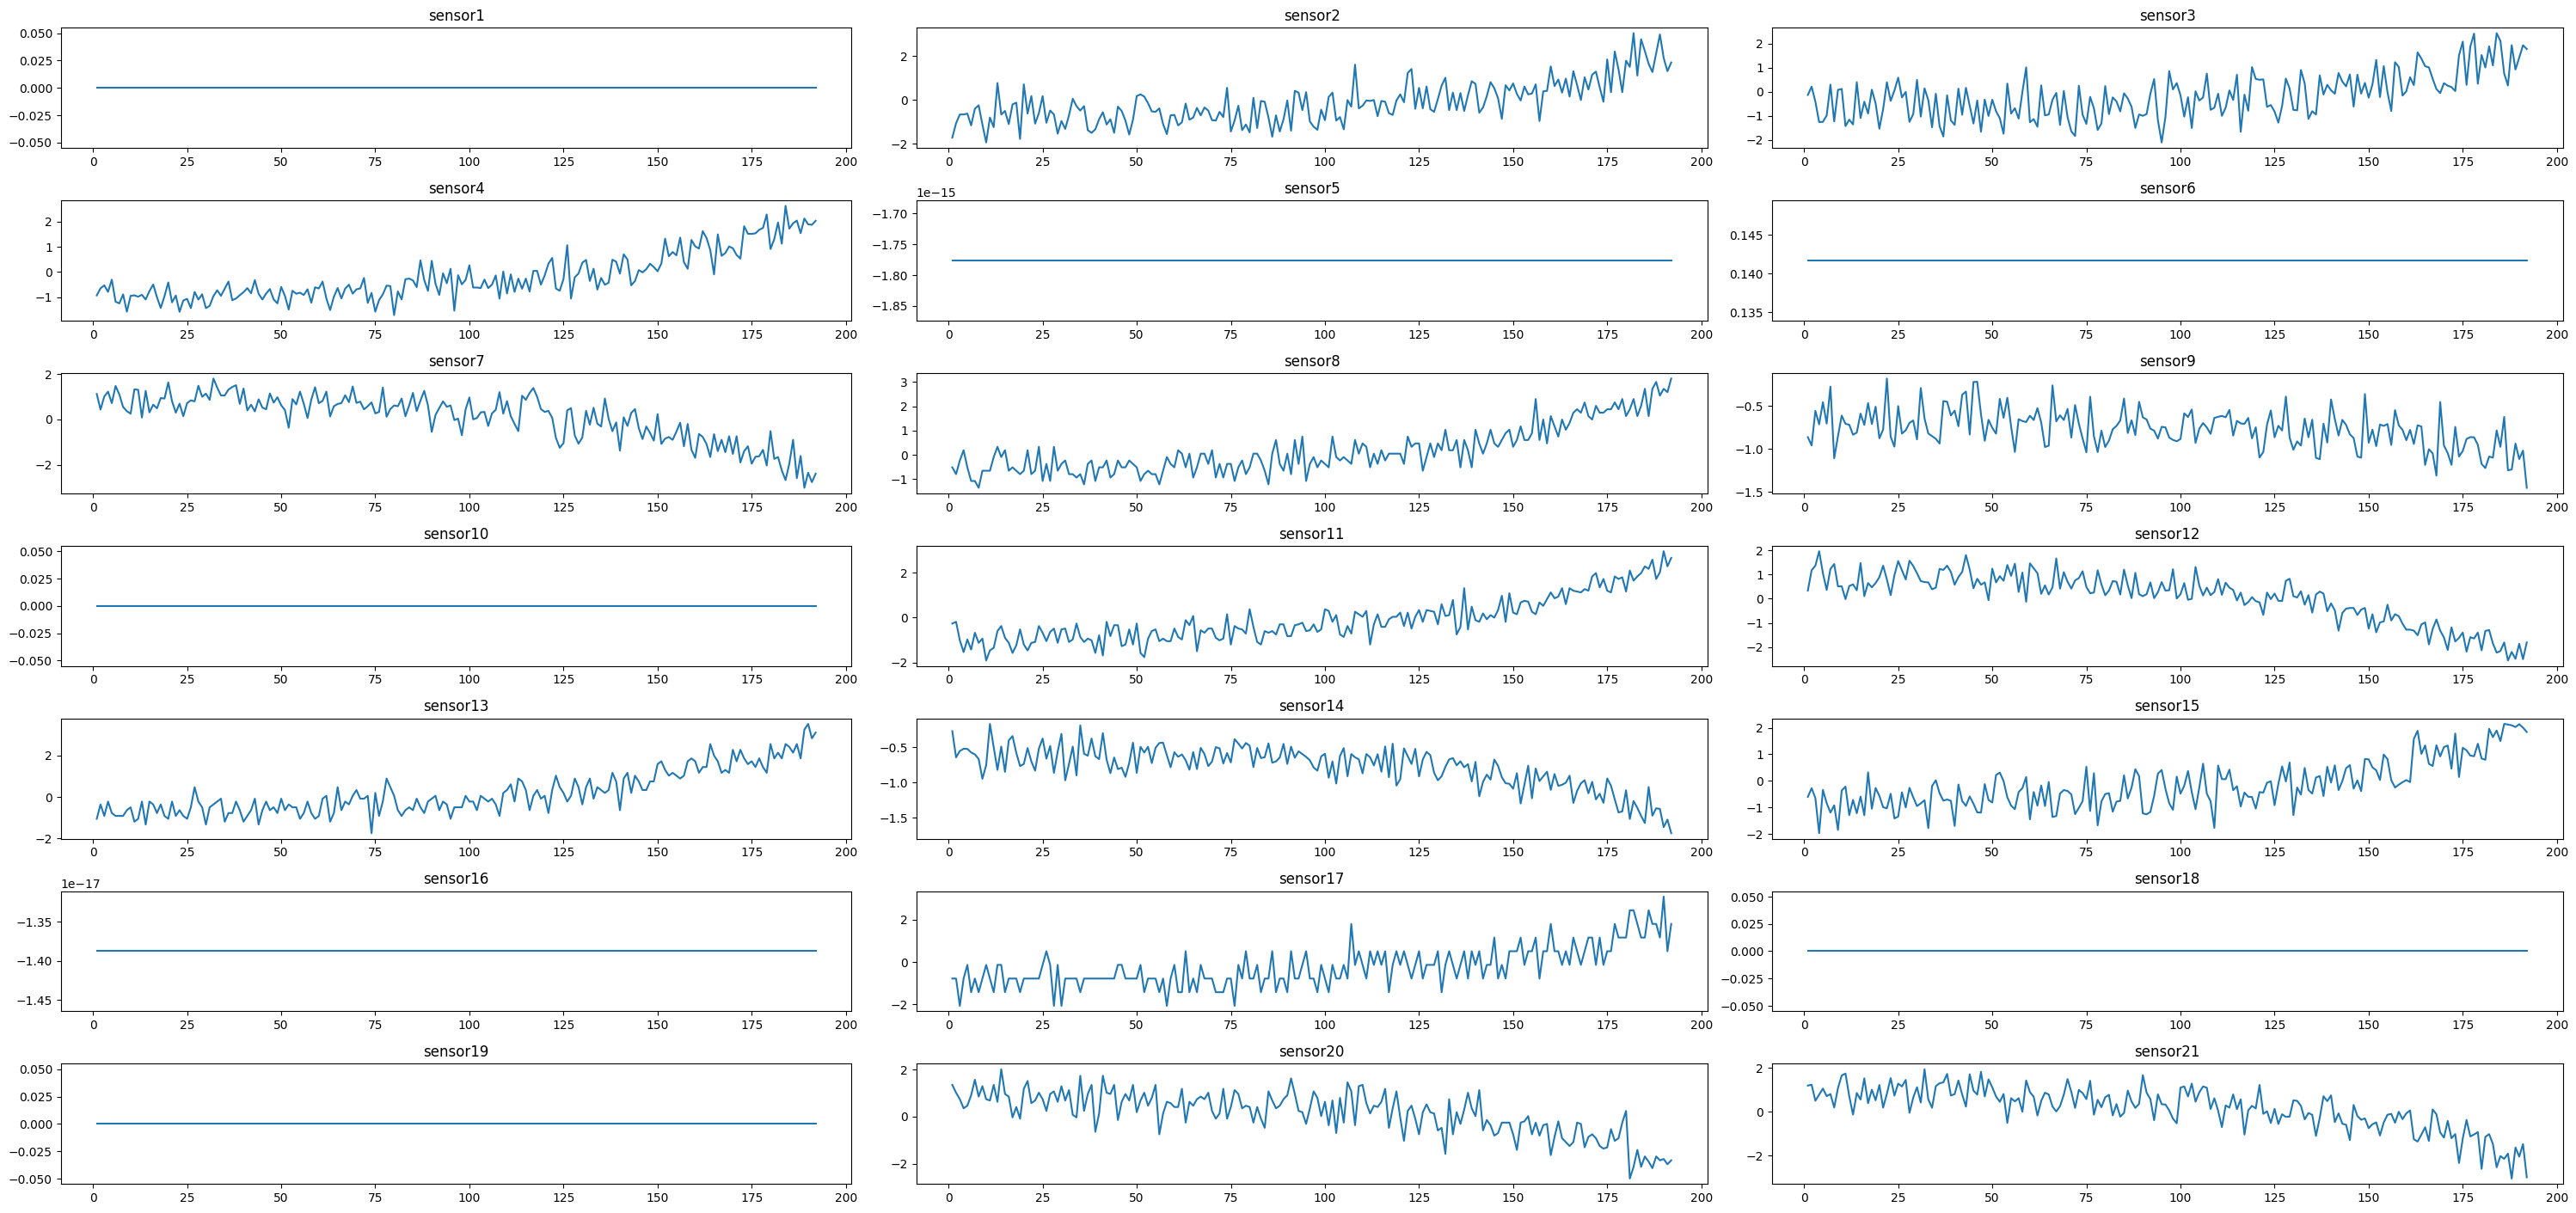

In [ ]:
plotSensorDataOfId(scaled_train, 1)

# Piece-wise data (all columns in order) with augmentation and padded sequence

In [ ]:
import random
def getPieceWiseData(data, augmentStartCycle=None, augmentEndCycle=None, movingAverage=None):
    uniqueIds = data['id'].unique()
    if movingAverage==None:
        result = [data[data['id']==mId].values for mId in uniqueIds]
    else:
        result = [data[data['id']==mId].rolling(movingAverage).mean().dropna().values for mId in uniqueIds]
    maxlen = np.max([len(x) for x in result])
    #Augment the data now
    if(augmentStartCycle!=None and augmentEndCycle!= None):
        result1 = []
        for mc in result:
            maxCycle = len(mc)
            for i in range(50):
                idx = random.randint(max([maxCycle-145, 10]), max([maxCycle-10, 10]))
                if(len(mc[:idx, :])>0):
                    result1.append(mc[:idx, :])
            #Also add the complete sequence.
#             result1.append(mc)
        result = result1
    # calculate the ruls (-1) is the last column for RUL
    ruls = [min(mc[:, -1]) for mc in result]
    return result,ruls, maxlen
# Use this last one only (prev one is a helper)
from keras.preprocessing.sequence import pad_sequences
def getPaddedSequence(data, pad_type='pre', maxlen=None, augmentStartCycle=None, augmentEndCycle=None, movingAverage=None):
    piece_wise, ruls, ml = getPieceWiseData(data, augmentStartCycle, augmentEndCycle, movingAverage)
    if(maxlen==None): maxlen = ml
    padded_sequence = pad_sequences(piece_wise, padding=pad_type, maxlen=maxlen, dtype='float32')
    return padded_sequence, ruls, maxlen

In [ ]:
augmentStartCycle = 130
augmentEndCycle = 362
maxlen=200
movingAverage = None
padded_train, train_ruls, maxlen = getPaddedSequence(scaled_train, maxlen=maxlen, augmentStartCycle=augmentStartCycle, augmentEndCycle=augmentEndCycle, movingAverage=movingAverage)
padded_test, test_ruls, maxlen = getPaddedSequence(scaled_test, maxlen=maxlen, movingAverage=movingAverage)

<Axes: ylabel='Density'>

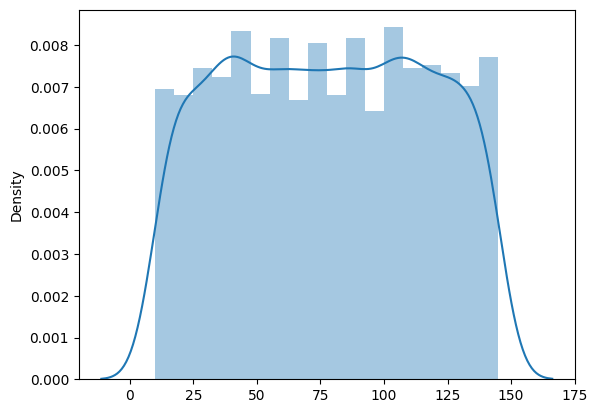

In [ ]:
sns.distplot(train_ruls)

# Plot data to see if it is smoothened.

In [ ]:
def plotDataForIndex(data, theIndex):
    plt.figure(figsize=(30, 30))
    for i in range(5, 26):
        plt.subplot(7, 3, i-4)
        values = data[theIndex][:, i]
        plt.plot(range(len(values)) ,values)
        plt.title('sensor'+str(i-4))
        plt.tight_layout()

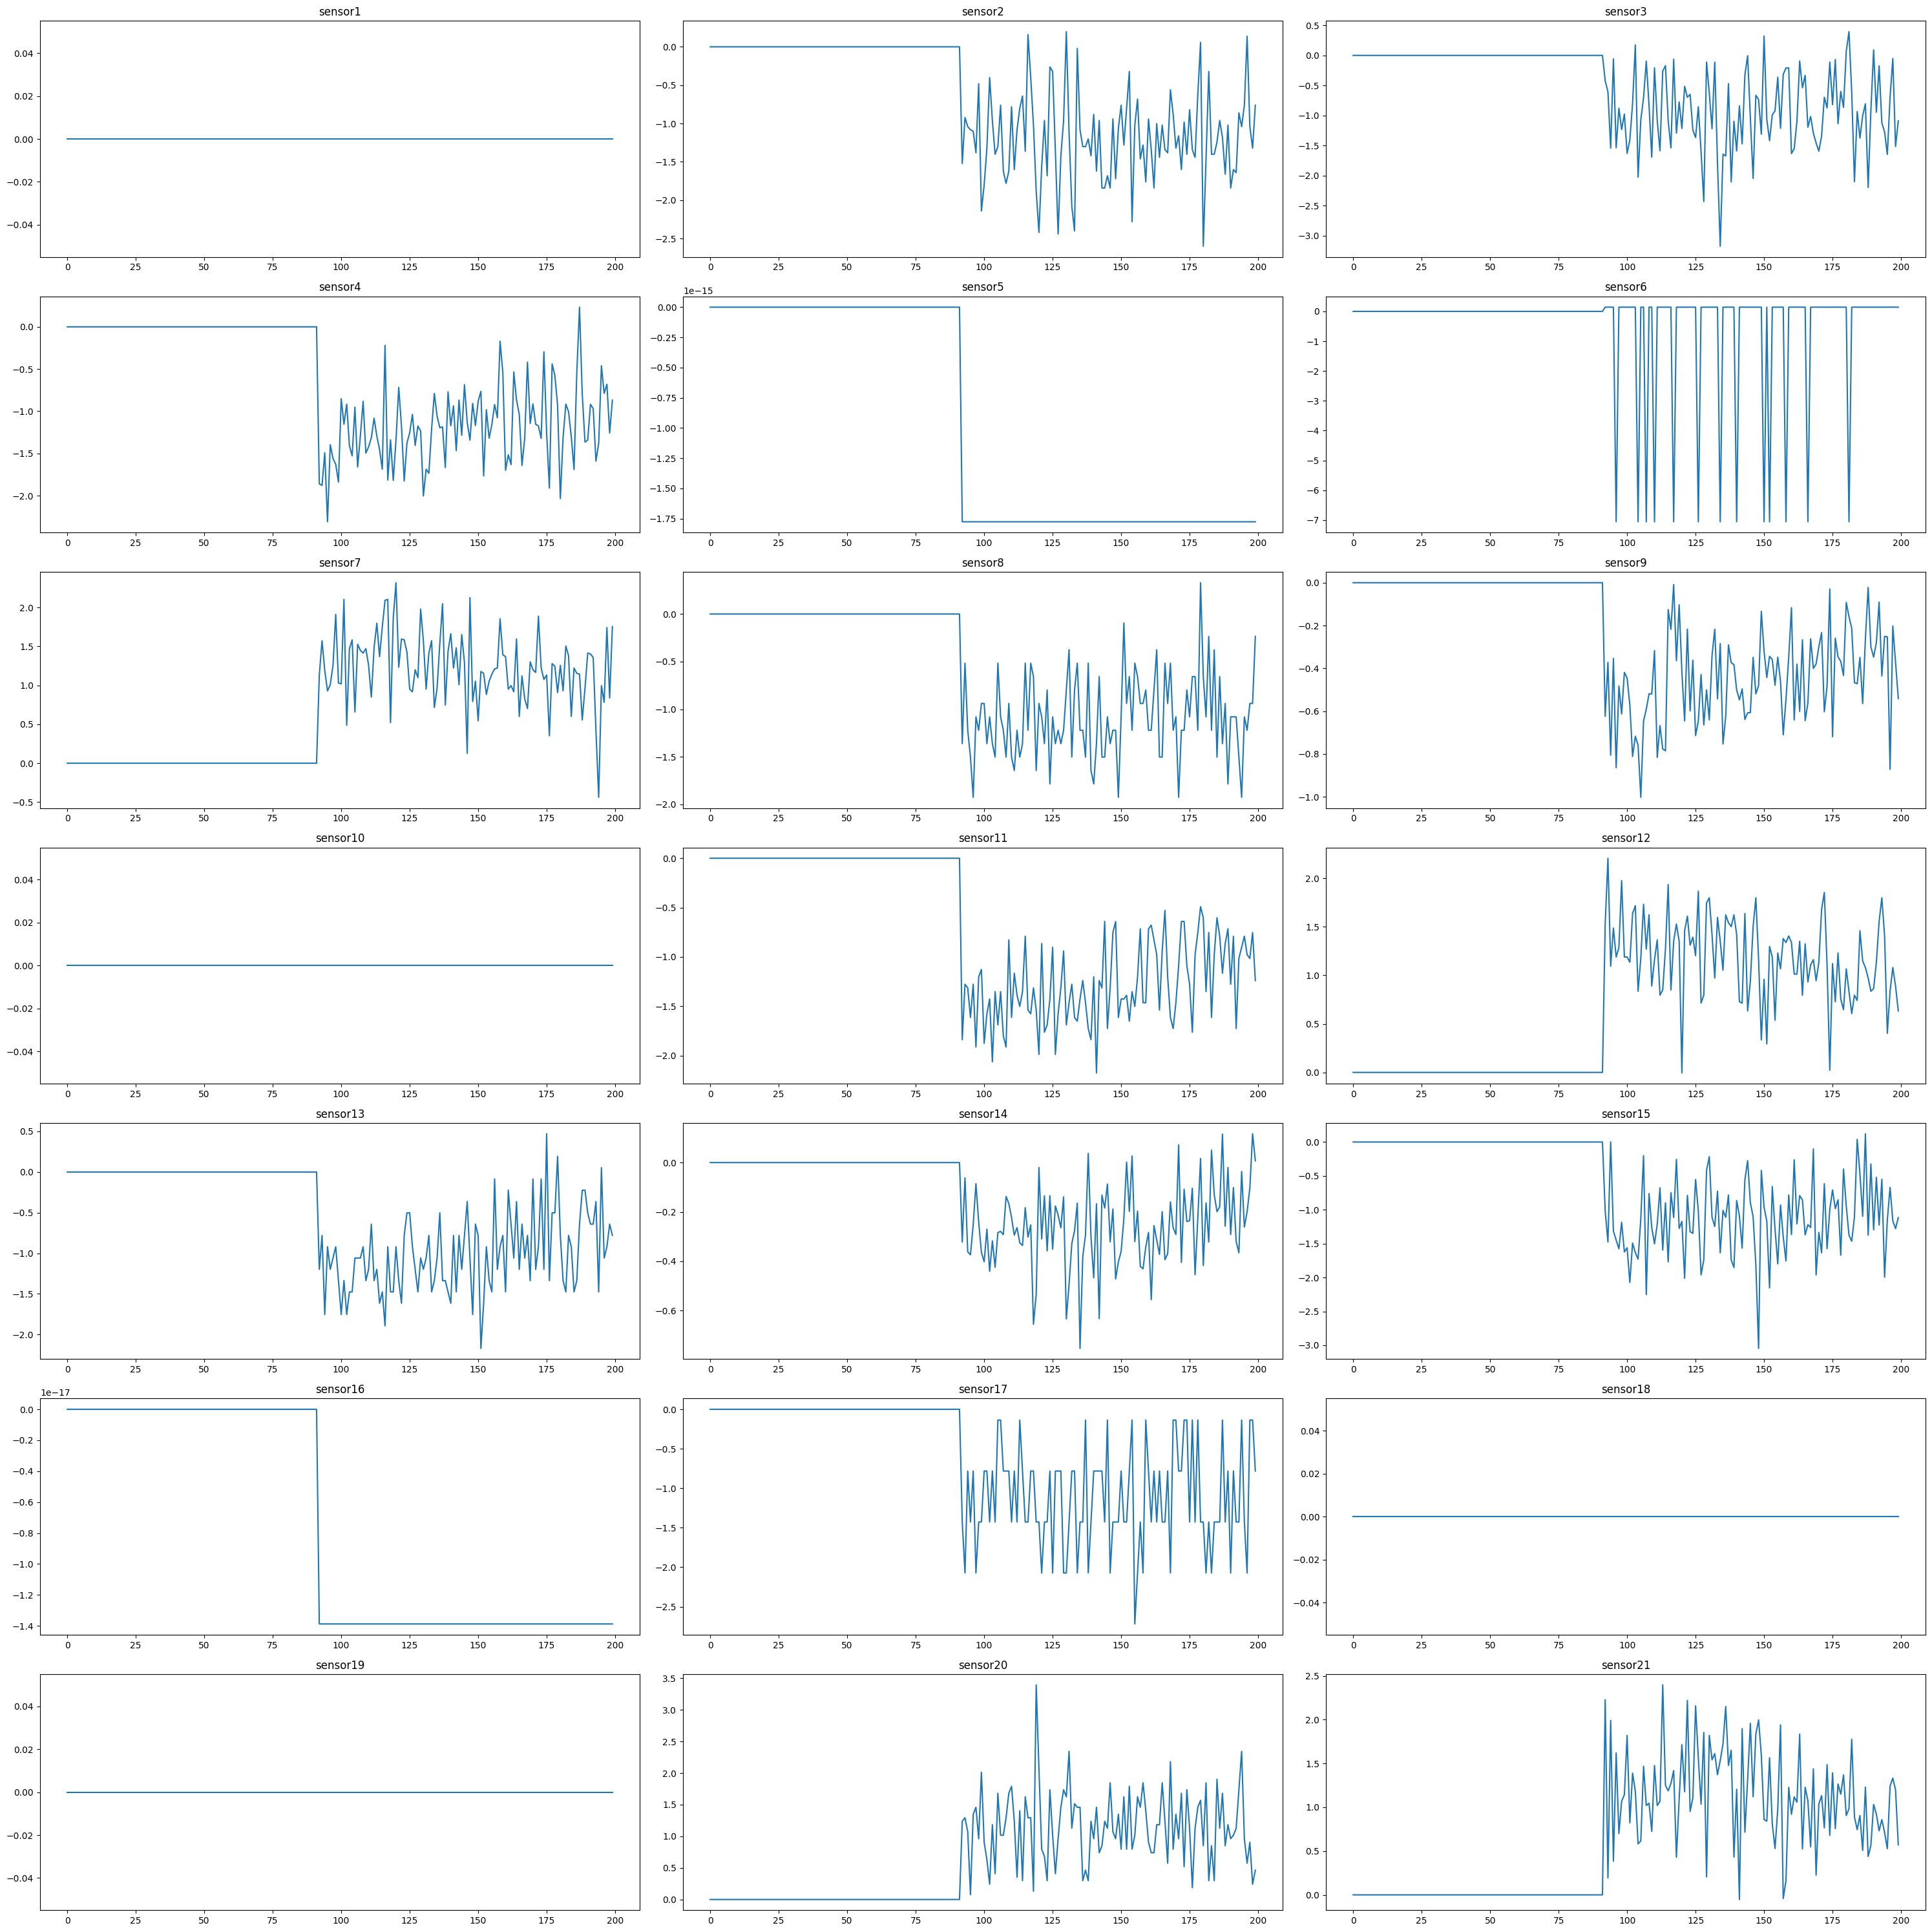

In [ ]:
plotDataForIndex(padded_train, 450)

# Select sensors

In [ ]:
# selected_sensors = [7, 8, 9, 12, 16, 17, 20]
selected_sensors = [2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 17, 20, 21]
# selected_sensors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
selected_sensors_indices = [x-1 for x in selected_sensors] # -1 because the index starts from 1

# Train test data

In [ ]:
# X_train = padded_train[:, :, 5:26]
X_train = padded_train[:, :, 5:26][:, :, selected_sensors_indices]

In [ ]:
# X_test = padded_test[:, :, 5:26]
X_test = padded_test[:, :, 5:26][:, :, selected_sensors_indices]

In [ ]:
y_train = np.array(train_ruls).reshape(-1,1)
y_test = np.array(test_ruls).reshape(-1,1)

In [ ]:
numOfSensors = len(X_train[0][0])

# Exporting and downloading data

In [ ]:
import codecs, json
def exportNPArrayToJSON(a, fileName):
    b = a.tolist() # nested lists with same data, indices
    json.dump(b, codecs.open(fileName, 'w', encoding='utf-8')) ### this saves the array in .json format

In [ ]:
test_FD = 'test_FD00' + str(setNumber) + ".json"
train_FD = 'train_FD00' + str(setNumber) + ".json"
test_RUL_FD = 'test_RUL_FD00' + str(setNumber) + ".json"
train_RUL_FD = 'train_RUL_FD00' + str(setNumber) + ".json"
# exportNPArrayToJSON(X_train, train_FD)
exportNPArrayToJSON(X_test, test_FD)
# exportNPArrayToJSON(y_train, train_RUL_FD)
exportNPArrayToJSON(y_test, test_RUL_FD)

In [ ]:
from IPython.display import FileLink

In [ ]:
FileLink(test_FD)

e:\IAD\Intern\05_CMAPSS\source\test_FD001.json

In [ ]:
FileLink(train_FD)

e:\IAD\Intern\05_CMAPSS\source\train_FD001.json

In [ ]:
FileLink(test_RUL_FD)

e:\IAD\Intern\05_CMAPSS\source\test_RUL_FD001.json

In [ ]:
FileLink(train_RUL_FD)

e:\IAD\Intern\05_CMAPSS\source\train_RUL_FD001.json

# LSTM Model

In [ ]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten

# from keras import backend as K
# K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=36, inter_op_parallelism_threads=36)))


def createModel(l1Nodes, l2Nodes, d1Nodes, d2Nodes, inputShape):
    # input layer
    lstm1 = LSTM(l1Nodes, input_shape=inputShape, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    do1 = Dropout(0.2)
    
    lstm2 = LSTM(l2Nodes, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    do2 = Dropout(0.2)
    
    flatten = Flatten()
    
    dense1 = Dense(d1Nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    do3 = Dropout(0.2)
    
    dense2 = Dense(d2Nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    do4 = Dropout(0.2)
    
    # output layer
    outL = Dense(1, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    # combine the layers
#     layers = [lstm1, do1, lstm2, do2, dense1, do3, dense2, do4, outL]
    layers = [lstm1, lstm2, do2, flatten,  dense1, dense2, outL]
    # create the model
    model = Sequential(layers)
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
model = createModel(64, 64, 64, 8, (maxlen, numOfSensors))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 200, 64)        │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 200, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       819,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 873,297 (3.33 MB)

 Trainable params: 873,297 (3.33 MB)

 Non-trainable params: 0 (0.00 B)

# CNN + LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Convolution1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout

In [ ]:
def createCNNLSTMModel(inputShape):
    cv1 = Convolution1D(input_shape=inputShape, filters=18, kernel_size=2, strides=1, padding='same', activation='relu', name='cv1')
    mp1 = MaxPooling1D(pool_size=2, strides=2, padding='same', name = 'mp1')
    
    cv2 = Convolution1D(filters=36, kernel_size=2, strides=1, padding='same', activation='relu', name='cv2')
    mp2 = MaxPooling1D(pool_size=2, strides=2, padding='same', name= 'mp2')
    
    cv3 = Convolution1D(filters=72, kernel_size=2, strides=1, padding='same', activation='relu', name='cv3')
    mp3 = MaxPooling1D(pool_size=2, strides=2, padding='same', name= 'mp3')
    
    d4 = Dense(inputShape[0]*inputShape[1], activation='relu')
    do4 = Dropout(0.2)
    
    lstm5 = LSTM(inputShape[1]*3, return_sequences=True)
    do5 = Dropout(0.2)
    
    lstm6 = LSTM(inputShape[1]*3)
    do6 = Dropout(0.2)
    
    d7 = Dense(50, activation='relu')
    do7 = Dropout(0.2)
    
    dout = Dense(1)
    
    model = Sequential([cv1, mp1, cv2, mp2, cv3, mp3, d4, do4, lstm5, do5, lstm6, do6, d7, do7, dout])
    model.compile(optimizer='rmsprop', loss='mse')
    return model

In [ ]:
# model = createCNNLSTMModel((maxlen, numOfSensors))

In [ ]:
# model.summary()

# Average model

In [ ]:
# from keras.models import Sequential
# from keras.layers import Convolution1D
# from keras.layers import MaxPooling1D
# from keras.layers import AveragePooling1D
# from keras.layers import Flatten
# from keras.layers import LSTM
# from keras.layers import Dense
# from keras.layers import Activation
# from keras.layers import Dropout

In [ ]:
# def createAVGLSTMModel(inputShape):
#     a1 = AveragePooling1D(pool_size=5,stride=1, padding='same', input_shape=inputShape)  
# #     d4 = Dense(inputShape[0]*inputShape[1], activation='relu')
# #     do4 = Dropout(0.5)
    
#     lstm5 = LSTM(64, return_sequences=True)
#     do5 = Dropout(0.5)
    
#     lstm6 = LSTM(64)
#     do6 = Dropout(0.5)
    
#     d7 = Dense(8, activation='relu')
#     do7 = Dropout(0.5)
    
#     d8 = Dense(8, activation='relu')
#     do8 = Dropout(0.5)

    
#     dout = Dense(1)
    
#     model = Sequential([a1, lstm5, do5, lstm6, do6, d7, do7, d8, do8, dout])
#     model.compile(optimizer='adam', loss='mse')
#     return model

In [ ]:
# model = createAVGLSTMModel((maxlen, numOfSensors))
# model.summary()

# Train/Fit model

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import load_model
# ten fold
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=3, shuffle=True)
from keras.models import load_model
msescores = []
counter= 0
for trainIdx, testIdx in kfold.split(X_train, y_train):
    counter = counter + 1
    # create callbacks
    model_path = 'best_model_set'+str(setNumber)+'fold'+str(counter)+'.keras'
    mc = ModelCheckpoint(model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    es = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1)
    # create model
    # model = createModel(64, 64, 8, 8, (maxlen, numOfSensors))
    model = createCNNLSTMModel((maxlen, numOfSensors))
    model.fit(X_train[trainIdx], y_train[trainIdx], validation_data=(X_train[testIdx], y_train[testIdx]), batch_size=32, epochs=4, callbacks=[mc, es])
    # Done load the best model of this fold
    saved_model = load_model(model_path)
    msescores.append({'path': model_path, 'mse': saved_model.evaluate(X_train[testIdx], y_train[testIdx])})

Epoch 1/4
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 5075.1621
Epoch 1: val_loss improved from inf to 1799.82214, saving model to best_model_set1fold1.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 22s 183ms/step - loss: 5062.9731 - val_loss: 1799.8221
Epoch 2/4
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 1675.2399
Epoch 2: val_loss improved from 1799.82214 to 1508.72168, saving model to best_model_set1fold1.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - loss: 1674.0616 - val_loss: 1508.7217
Epoch 3/4
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 1566.5817
Epoch 3: val_loss improved from 1508.72168 to 1507.62097, saving model to best_model_set1fold1.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - loss: 1566.8768 - val_loss: 1507.6210
Epoch 4/4
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 1599.3124
Epoch 4: val_loss improved from 1507.62097 to 1257.84790, saving model to best_model_set1fold1.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 1598.6190 - val_loss:

In [ ]:
msescores

[{'path': 'best_model_set1fold1.keras', 'mse': 1257.847900390625},
 {'path': 'best_model_set1fold2.keras', 'mse': 1504.3905029296875},
 {'path': 'best_model_set1fold3.keras', 'mse': 830.908447265625}]

In [ ]:

for md in msescores:
    saved_model = load_model(md['path'])
    print(saved_model.evaluate(X_test, y_test))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - loss: 1299.6001
1421.243408203125
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - loss: 1582.0201
1733.7762451171875
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - loss: 981.3804
957.3038330078125


In [ ]:
predicted = saved_model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step


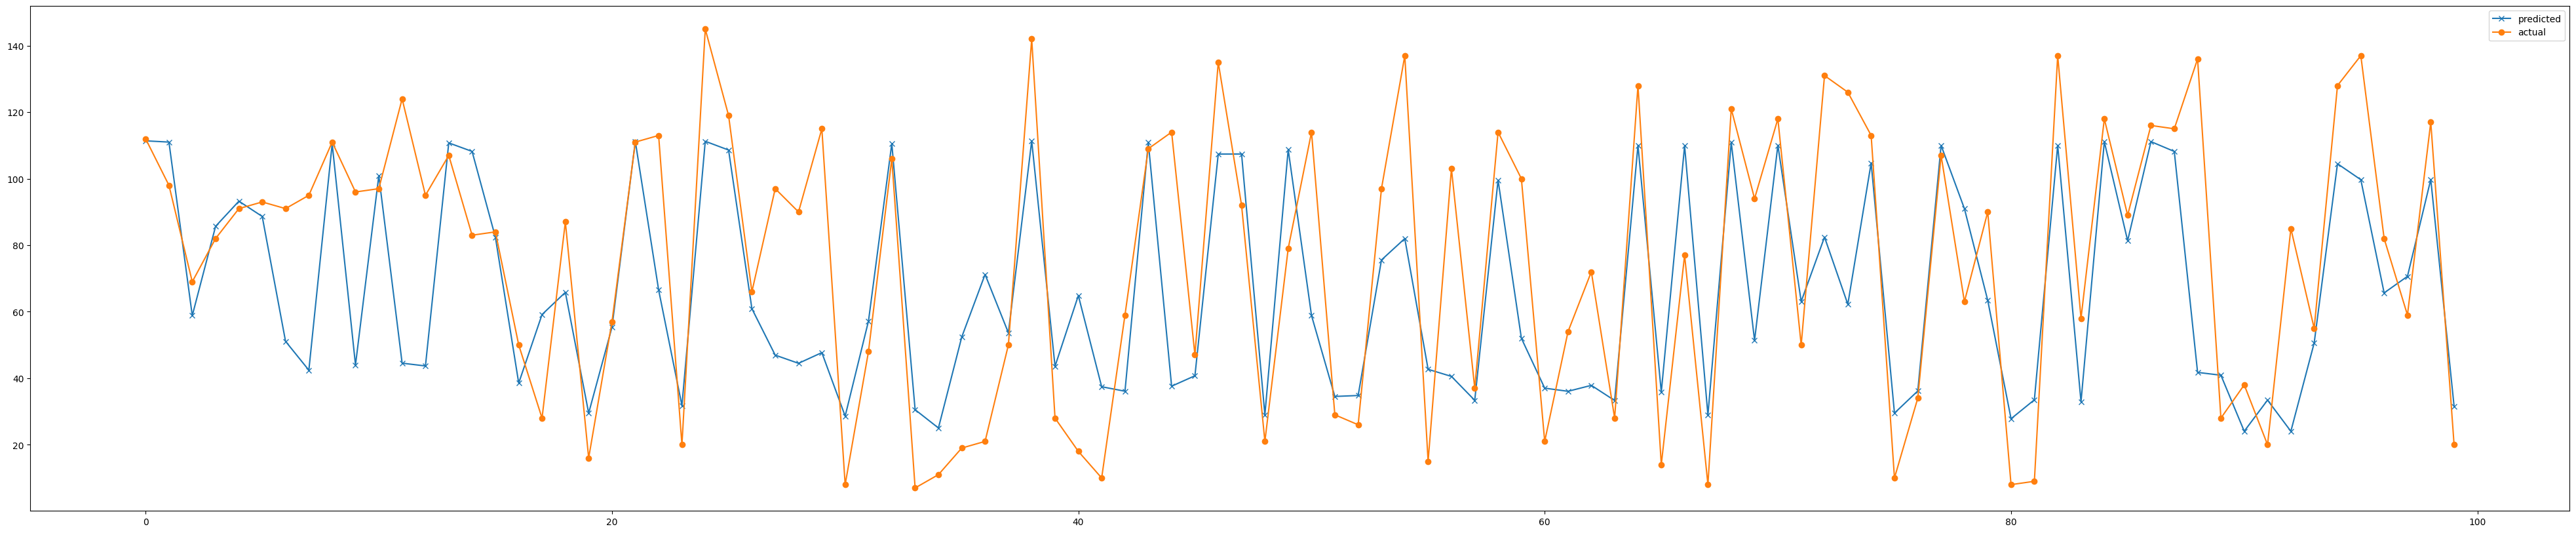

In [ ]:
plt.figure(figsize=(50, 10))
plt.plot(range(len(predicted)), predicted, '-x', label='predicted')
plt.plot(range(len(y_test)), y_test, '-o', label='actual')
plt.legend()